In [1]:
import sys
import os

pathModules = os.path.abspath("C:\Alexandre\M2 - IPP Sorbonne\Project_fracture\code\modules")
sys.path.append(pathModules)

print(pathModules)
assert os.path.isdir(pathModules)

C:\Alexandre\M2 - IPP Sorbonne\Project_fracture\code\modules


In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import time_to_H
import compute_flexion as flex
import parameters as setup

In [11]:
# Read data

folder_fields = os.path.abspath("./muDIC")
dt_camera = 0.1

frames_true = np.load(os.path.join(folder_fields, "frames.npy"))
coords = np.load(os.path.join(folder_fields, "coords.npy"))
trueStrain = np.load(os.path.join(folder_fields, "true_strain.npy"))

times = dt_camera * frames_true

# Only keep rinsing part
maskUp = (times < time_to_H.compute_time_rising(Hmax=setup.Hmax, vMax=setup.vmax, aMax=setup.amax))
times = times[maskUp]
frames_true = frames_true[maskUp]
coords = coords[:,:,:,:,maskUp]
trueStrain = trueStrain[:,:,:,:,:,maskUp]

heights = time_to_H.time_to_H(times, Hmax=setup.Hmax, vMax=setup.vmax, aMax=setup.amax)

with open(os.path.join(folder_fields, 'params.txt')) as file:
    params = file.read()

print(f"Frames: {frames_true.shape}")
print(f"Coords: {coords.shape}")
print(f"True strain: {trueStrain.shape}")

Frames: (102,)
Coords: (1, 2, 35, 30, 102)
True strain: (1, 2, 2, 35, 30, 102)


## Visualization

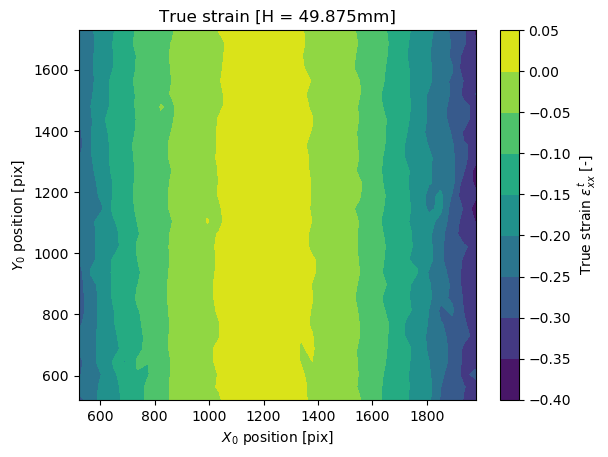

In [12]:
# Plot one frame

frame_index = -1
frame_true = frames_true[frame_index]

x0 = coords[0,0,:,:,0]
y0 = coords[0,1,:,:,0]

trueStrain_toPlot = trueStrain[0,0,0,:,:,frame_index]

fig, ax = plt.subplots()
ax.set_title(f"True strain [H = {heights[frame_index] * 1e3}mm]")

im = ax.contourf(x0, y0, trueStrain_toPlot)
fig.colorbar(im, ax=ax, label="True strain $\epsilon^t_{xx}$ [-]")

ax.set_xlabel('$X_0$ position [pix]')
ax.set_ylabel('$Y_0$ position [pix]')

plt.show()

102 frames


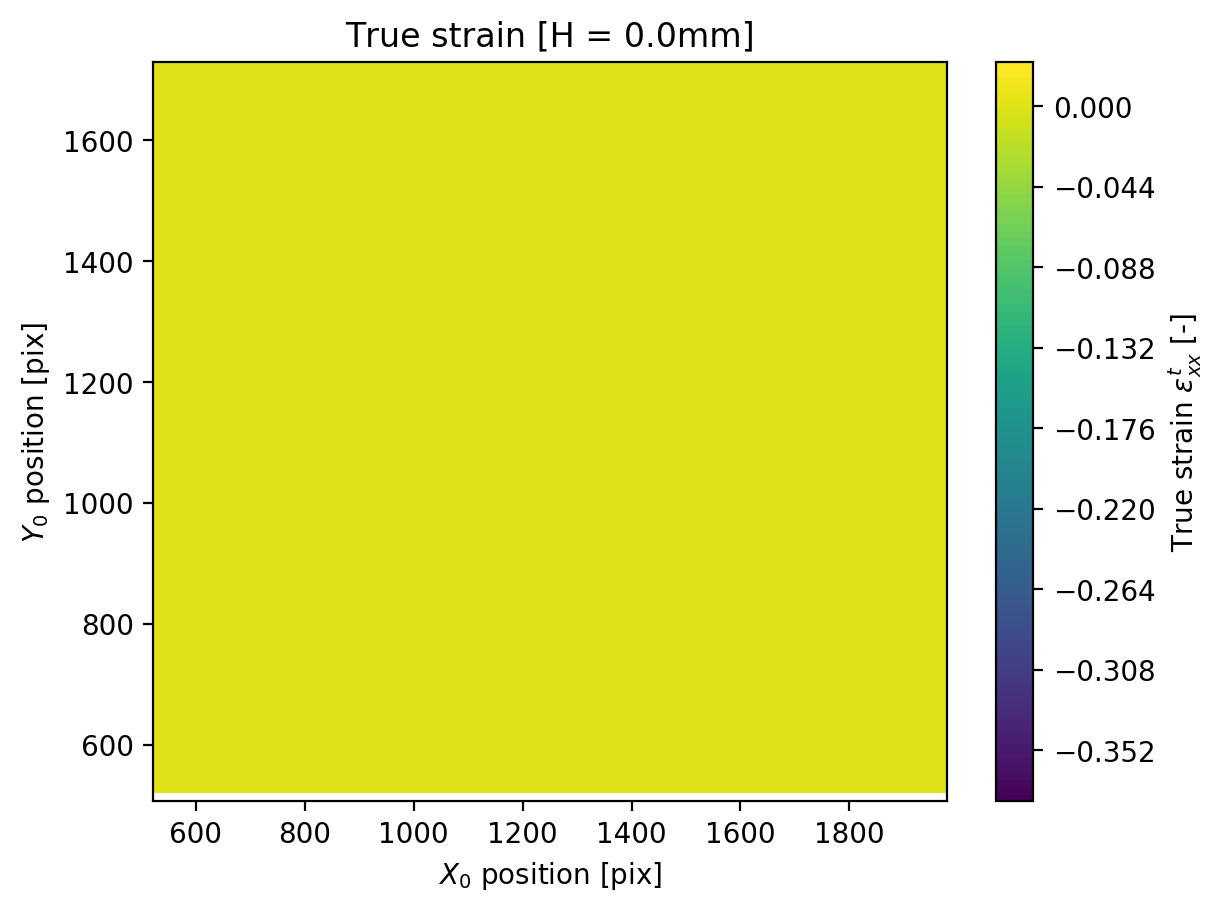

In [13]:
# Plot animation

nbFrames = coords.shape[-1]
frame_start = -1

fig, ax = plt.subplots()
fig.set_dpi(200)

# Set labels
ax.set_title(f"True strain [H = {heights[frame_start] * 1e3:.1f}mm]")
ax.set_xlabel('$X_0$ position [pix]')
ax.set_ylabel('$Y_0$ position [pix]')

# Set bounds
xbounds = coords[0,0,:,0,:].min(), coords[0,0,:,0,:].max()
ybounds = coords[0,1,:,0,:].min(), coords[0,1,0,:,:].max()
ax.set_xbound(*xbounds)
ax.set_ybound(*ybounds)

# Set static cmap
vmin, vmax = trueStrain[0,0,0,:,:,1:].min(), trueStrain[0,0,0,:,:,1:].max()
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap('viridis')
n_levels = 100

# Plot last frame
x = coords[0,0,:,:,frame_start]
y = coords[0,1,:,:,frame_start]
trueStrain_toPlot = trueStrain[0,0,0,:,:,frame_start]

cont = ax.contourf(x, y, trueStrain_toPlot, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont, ax=ax, label="True strain $\epsilon^t_{xx}$ [-]")


def update(frame_index):
    global cont

    x = coords[0,0,:,:,frame_index]
    y = coords[0,1,:,:,frame_index]
    trueStrain_toPlot = trueStrain[0,0,0,:,:,frame_index]
    
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact

    cont = plt.contourf(x, y, trueStrain_toPlot, levels=n_levels, cmap=cmap, norm=norm)

    # Set limits and title
    ax.set_title(f"True strain [H = {heights[frame_index] * 1e3:.1f}mm]")
    ax.set_xbound(*xbounds)
    ax.set_ybound(*ybounds)
    
    return cont

anim = animation.FuncAnimation(fig, update, frames=nbFrames, repeat=False, interval=100)
print(f"{nbFrames} frames")

anim_html = HTML(anim.to_html5_video())

In [14]:
# Display animation

anim_html

In [16]:
# Save animation

savepath = os.path.join(folder_fields, "animation_trueStrain.html")
with open(savepath, 'w') as f:
    f.write(anim_html.data)

[2, 6, 11, 16, 21, 25, 30]


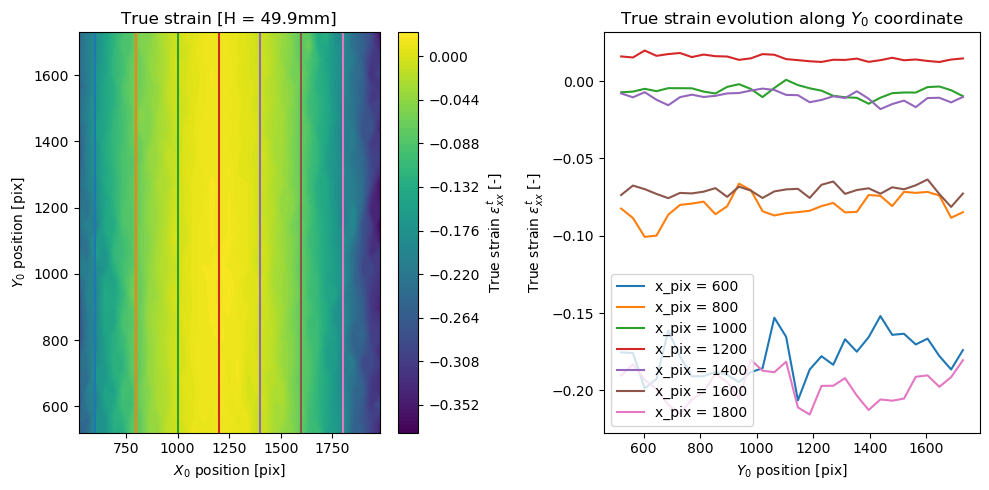

In [25]:
# Check invariance along y

frame_index = -1
x_pix_list = [600, 800, 1000, 1200, 1400, 1600, 1800]
#x_pix_list = [800, 1200, 1600]

x0 = coords[0,0,:,:,0]
y0 = coords[0,1,:,:,0]
trueStrain_frame = trueStrain[0,0,0,:,:,frame_index]

# Find nearest element for each y_pix
x_elem_list = []
for x_pix in x_pix_list:
    x_elem = np.argmin(np.abs(x_pix - x0[:,x0.shape[0]//2]))
    x_elem_list.append(x_elem)

# Plot ax1: contourf with lines; ax2: strain along y
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

ax1.set_title(f'True strain [H = {heights[frame_index] * 1e3:.1f}mm]')
ax2.set_title('True strain evolution along $Y_0$ coordinate')

cont = ax1.contourf(x0, y0, trueStrain_frame, cmap='viridis', levels=100)
fig.colorbar(cont, ax=ax1, label='True strain $\epsilon^t_{xx}$ [-]')

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

strains_evol_y = []
for i in range(len(x_pix_list)):
    x_pix, x_elem = x_pix_list[i], x_elem_list[i]
    color = color_cycle[i]

    ax1.axvline(x_pix, c=color)
    ax2.plot(y0[x_elem,:], trueStrain_frame[x_elem,:], c=color, label=f"x_pix = {x_pix}")
    strains_evol_y.append(trueStrain_frame[x_elem,:])

ax2.legend()

ax1.set_xlabel('$X_0$ position [pix]')
ax1.set_ylabel('$Y_0$ position [pix]')
ax2.set_xlabel('$Y_0$ position [pix]')
ax2.set_ylabel('True strain $\epsilon^t_{xx}$ [-]')

print(x_elem_list)
plt.show()


Height: 50 mm
[2, 6, 11, 16, 21, 25, 30]


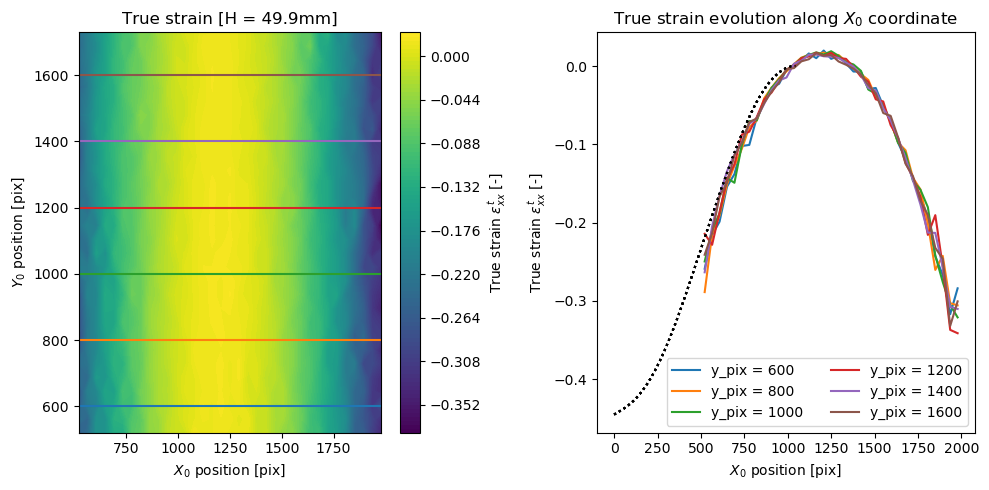

In [26]:
# Check evolution along x

frame_index = -1
y_pix_list = [600, 800, 1000, 1200, 1400, 1600]
#y_pix_list = [800, 1200, 1600]

# Compute theoretical visual_strain
dt_camera = 1e-1
frame_true = frames_true[frame_index]
H = time_to_H.time_to_H(frame_true * dt_camera)
df, dict_sol = flex.solve_flexion(setup.W, H, setup.a)

print(f"Height: {1e3 * H:.0f} mm")

# Get coordinates and true strain
x0 = coords[0,0,:,:,0]
y0 = coords[0,1,:,:,0]
trueStrain_frame = trueStrain[0,0,0,:,:,frame_index]

# Find nearest element for each y_pix
y_elem_list = []
for y_pix in y_pix_list:
    y_elem = np.argmin(np.abs(y_pix - y0[y0.shape[0]//2,:]))
    y_elem_list.append(y_elem)

# Plot ax1: contourf with lines; ax2: strain along y
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

ax1.set_title(f'True strain [H = {heights[frame_index] * 1e3:.1f}mm]')
ax2.set_title('True strain evolution along $X_0$ coordinate')

cont = ax1.contourf(x0, y0, trueStrain_frame, cmap='viridis', levels=100)
fig.colorbar(cont, ax=ax1, label='True strain $\epsilon^t_{xx}$ [-]')

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

strain_evol_x = []
for i in range(len(y_pix_list)):
    y_pix, y_elem = y_pix_list[i], y_elem_list[i]
    color = color_cycle[i]

    ax1.axhline(y_pix, c=color)
    ax2.plot(x0[:,y_elem], trueStrain_frame[:,y_elem], c=color, label=f"y_pix = {y_pix}")
    ax2.plot(10000 * df['S'].to_numpy(), df['trueStrain_visu'].to_numpy(), ls=':', c='k')
    strain_evol_x.append(trueStrain_frame[:,y_elem])

ax2.legend(ncol=2)

ax1.set_xlabel('$X_0$ position [pix]')
ax1.set_ylabel('$Y_0$ position [pix]')
ax2.set_xlabel('$X_0$ position [pix]')
ax2.set_ylabel('True strain $\epsilon^t_{xx}$ [-]')

print(x_elem_list)
plt.show()

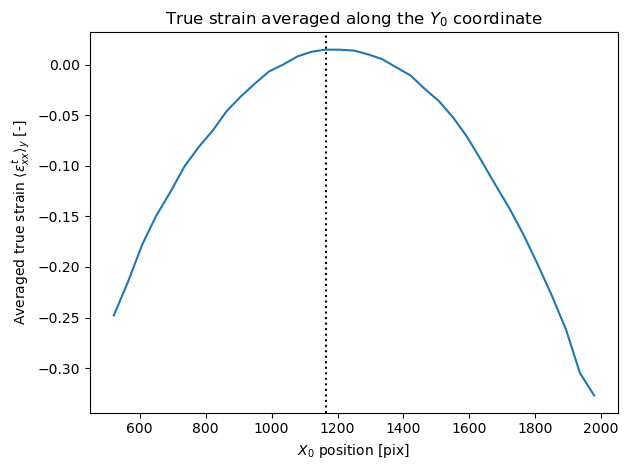

In [27]:
# Average strain along y

avg_x = x0.mean(axis=1)
avg_trueStrain = trueStrain_frame.mean(axis=1)

argmax_strain = avg_trueStrain.argmax()

fig, ax = plt.subplots(tight_layout=True)

ax.plot(avg_x, avg_trueStrain)
ax.axvline(avg_x[argmax_strain], ls=':', c='k')

ax.set_xlabel('$X_0$ position [pix]')
ax.set_ylabel('Averaged true strain $\langle \epsilon^t_{xx} \\rangle_y$ [-]')

ax.set_title("True strain averaged along the $Y_0$ coordinate")

plt.show()

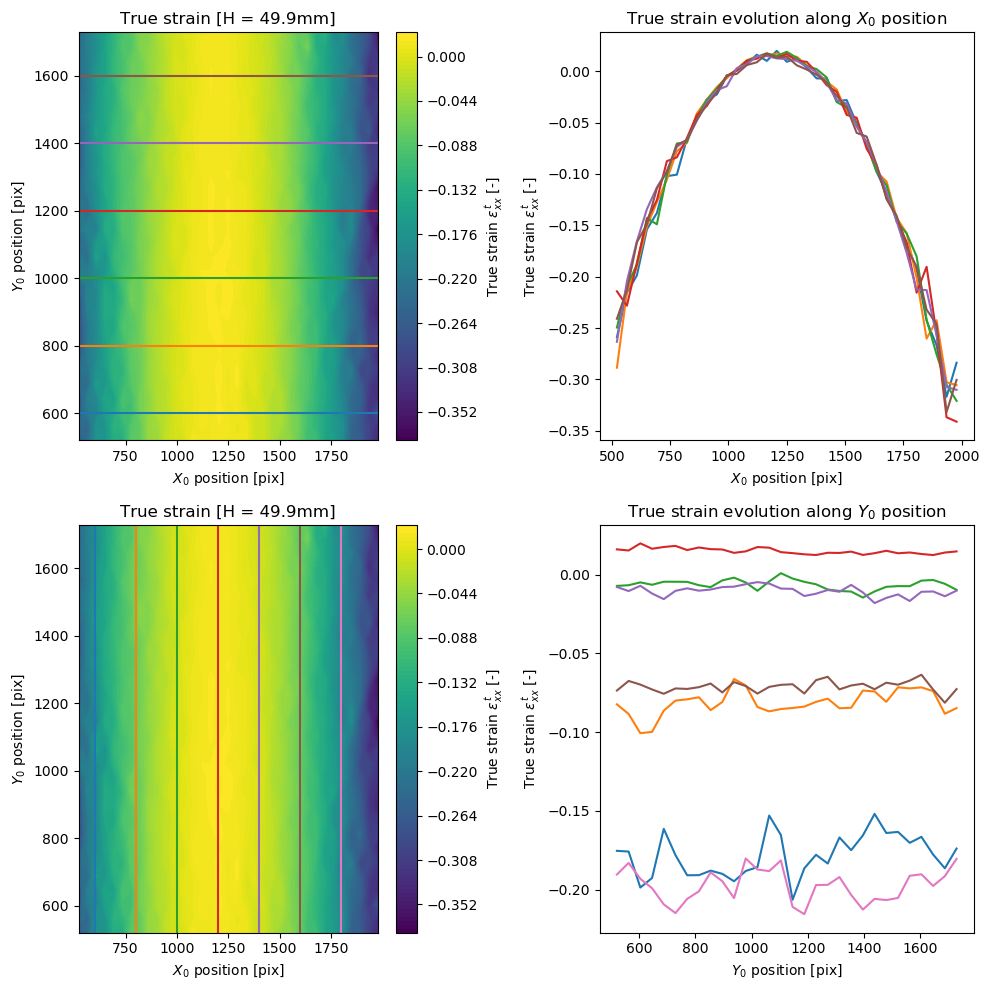

In [28]:
# Plot evolution of strain along x0 and y0 directions

nbFrames = coords.shape[-1]
frame_index_start = -1

x_pix_list = [600, 800, 1000, 1200, 1400, 1600, 1800]
y_pix_list = [600, 800, 1000, 1200, 1400, 1600]

# Find nearest elements
x_elem_list = []
y_elem_list = []
for y_pix in y_pix_list:
    y_elem = np.argmin(np.abs(y_pix - y0[y0.shape[0]//2,:]))
    y_elem_list.append(y_elem)
for x_pix in x_pix_list:
    x_elem = np.argmin(np.abs(x_pix - x0[:,x0.shape[0]//2]))
    x_elem_list.append(x_elem)


fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=2, tight_layout=True)

# Set labels
for i in range(2):
    ax[i,0].set_title(f"True strain [H = {heights[frame_index_start] * 1e3:.1f}mm]")
    ax[i,0].set_xlabel('$X_0$ position [pix]')
    ax[i,0].set_ylabel('$Y_0$ position [pix]')
ax[0,1].set_xlabel('$X_0$ position [pix]')
ax[1,1].set_xlabel('$Y_0$ position [pix]')
ax[0,1].set_ylabel('True strain $\epsilon^t_{xx}$ [-]')
ax[1,1].set_ylabel('True strain $\epsilon^t_{xx}$ [-]')
ax[0,1].set_title("True strain evolution along $X_0$ position")
ax[1,1].set_title("True strain evolution along $Y_0$ position")

# Set bounds
xbounds = coords[0,0,:,0,:].min(), coords[0,0,:,0,:].max()
ybounds = coords[0,1,:,0,:].min(), coords[0,1,0,:,:].max()
for i in range(2):
    ax[i,0].set_xbound(*xbounds)
    ax[i,0].set_ybound(*ybounds)
ybounds_x = trueStrain[0,0,0,x_elem_list,:,:].min(), trueStrain[0,0,0,x_elem_list,:,:].max()
ybounds_y = trueStrain[0,0,0,:,y_elem_list,:].min(), trueStrain[0,0,0,:,y_elem_list,:].max()
ax[0,1].set_ybound(*ybounds_y)
ax[1,1].set_ybound(*ybounds_x)

# Set static cmap
vmin, vmax = trueStrain[0,0,0,:,:,1:].min(), trueStrain[0,0,0,:,:,1:].max()
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap('viridis')
n_levels = 100

# Plot last frame
x0 = coords[0,0,:,:,0]
y0 = coords[0,1,:,:,0]
trueStrain_toPlot = trueStrain[0,0,0,:,:,frame_start]

# Contour plots
cont0 = ax[0,0].contourf(x0, y0, trueStrain_toPlot, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont0, ax=ax[0,0], label="True strain $\epsilon^t_{xx}$ [-]")
cont1 = ax[1,0].contourf(x0, y0, trueStrain_toPlot, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont1, ax=ax[1,0], label="True strain $\epsilon^t_{xx}$ [-]")

# Line sections
lines_y = [ax[0,1].plot(x0[:,y_elem], trueStrain_toPlot[:,y_elem], c=color, label=f"y_pix = {y_pix}")
           for y_elem, y_pix, color in zip(y_elem_list, y_pix_list, color_cycle)]
lines_x = [ax[1,1].plot(y0[x_elem,:], trueStrain_toPlot[x_elem,:], c=color, label=f"x_pix = {x_pix}")
           for x_elem, x_pix, color in zip(x_elem_list, x_pix_list, color_cycle)]

# Vert/Horiz lines
lines_horiz_y = [ax[0,0].axhline(y_pix, c=color) for y_pix, color in zip(y_pix_list, color_cycle)]
lines_vert_x = [ax[1,0].axvline(x_pix, c=color) for x_pix, color in zip(x_pix_list, color_cycle)]


102 frames


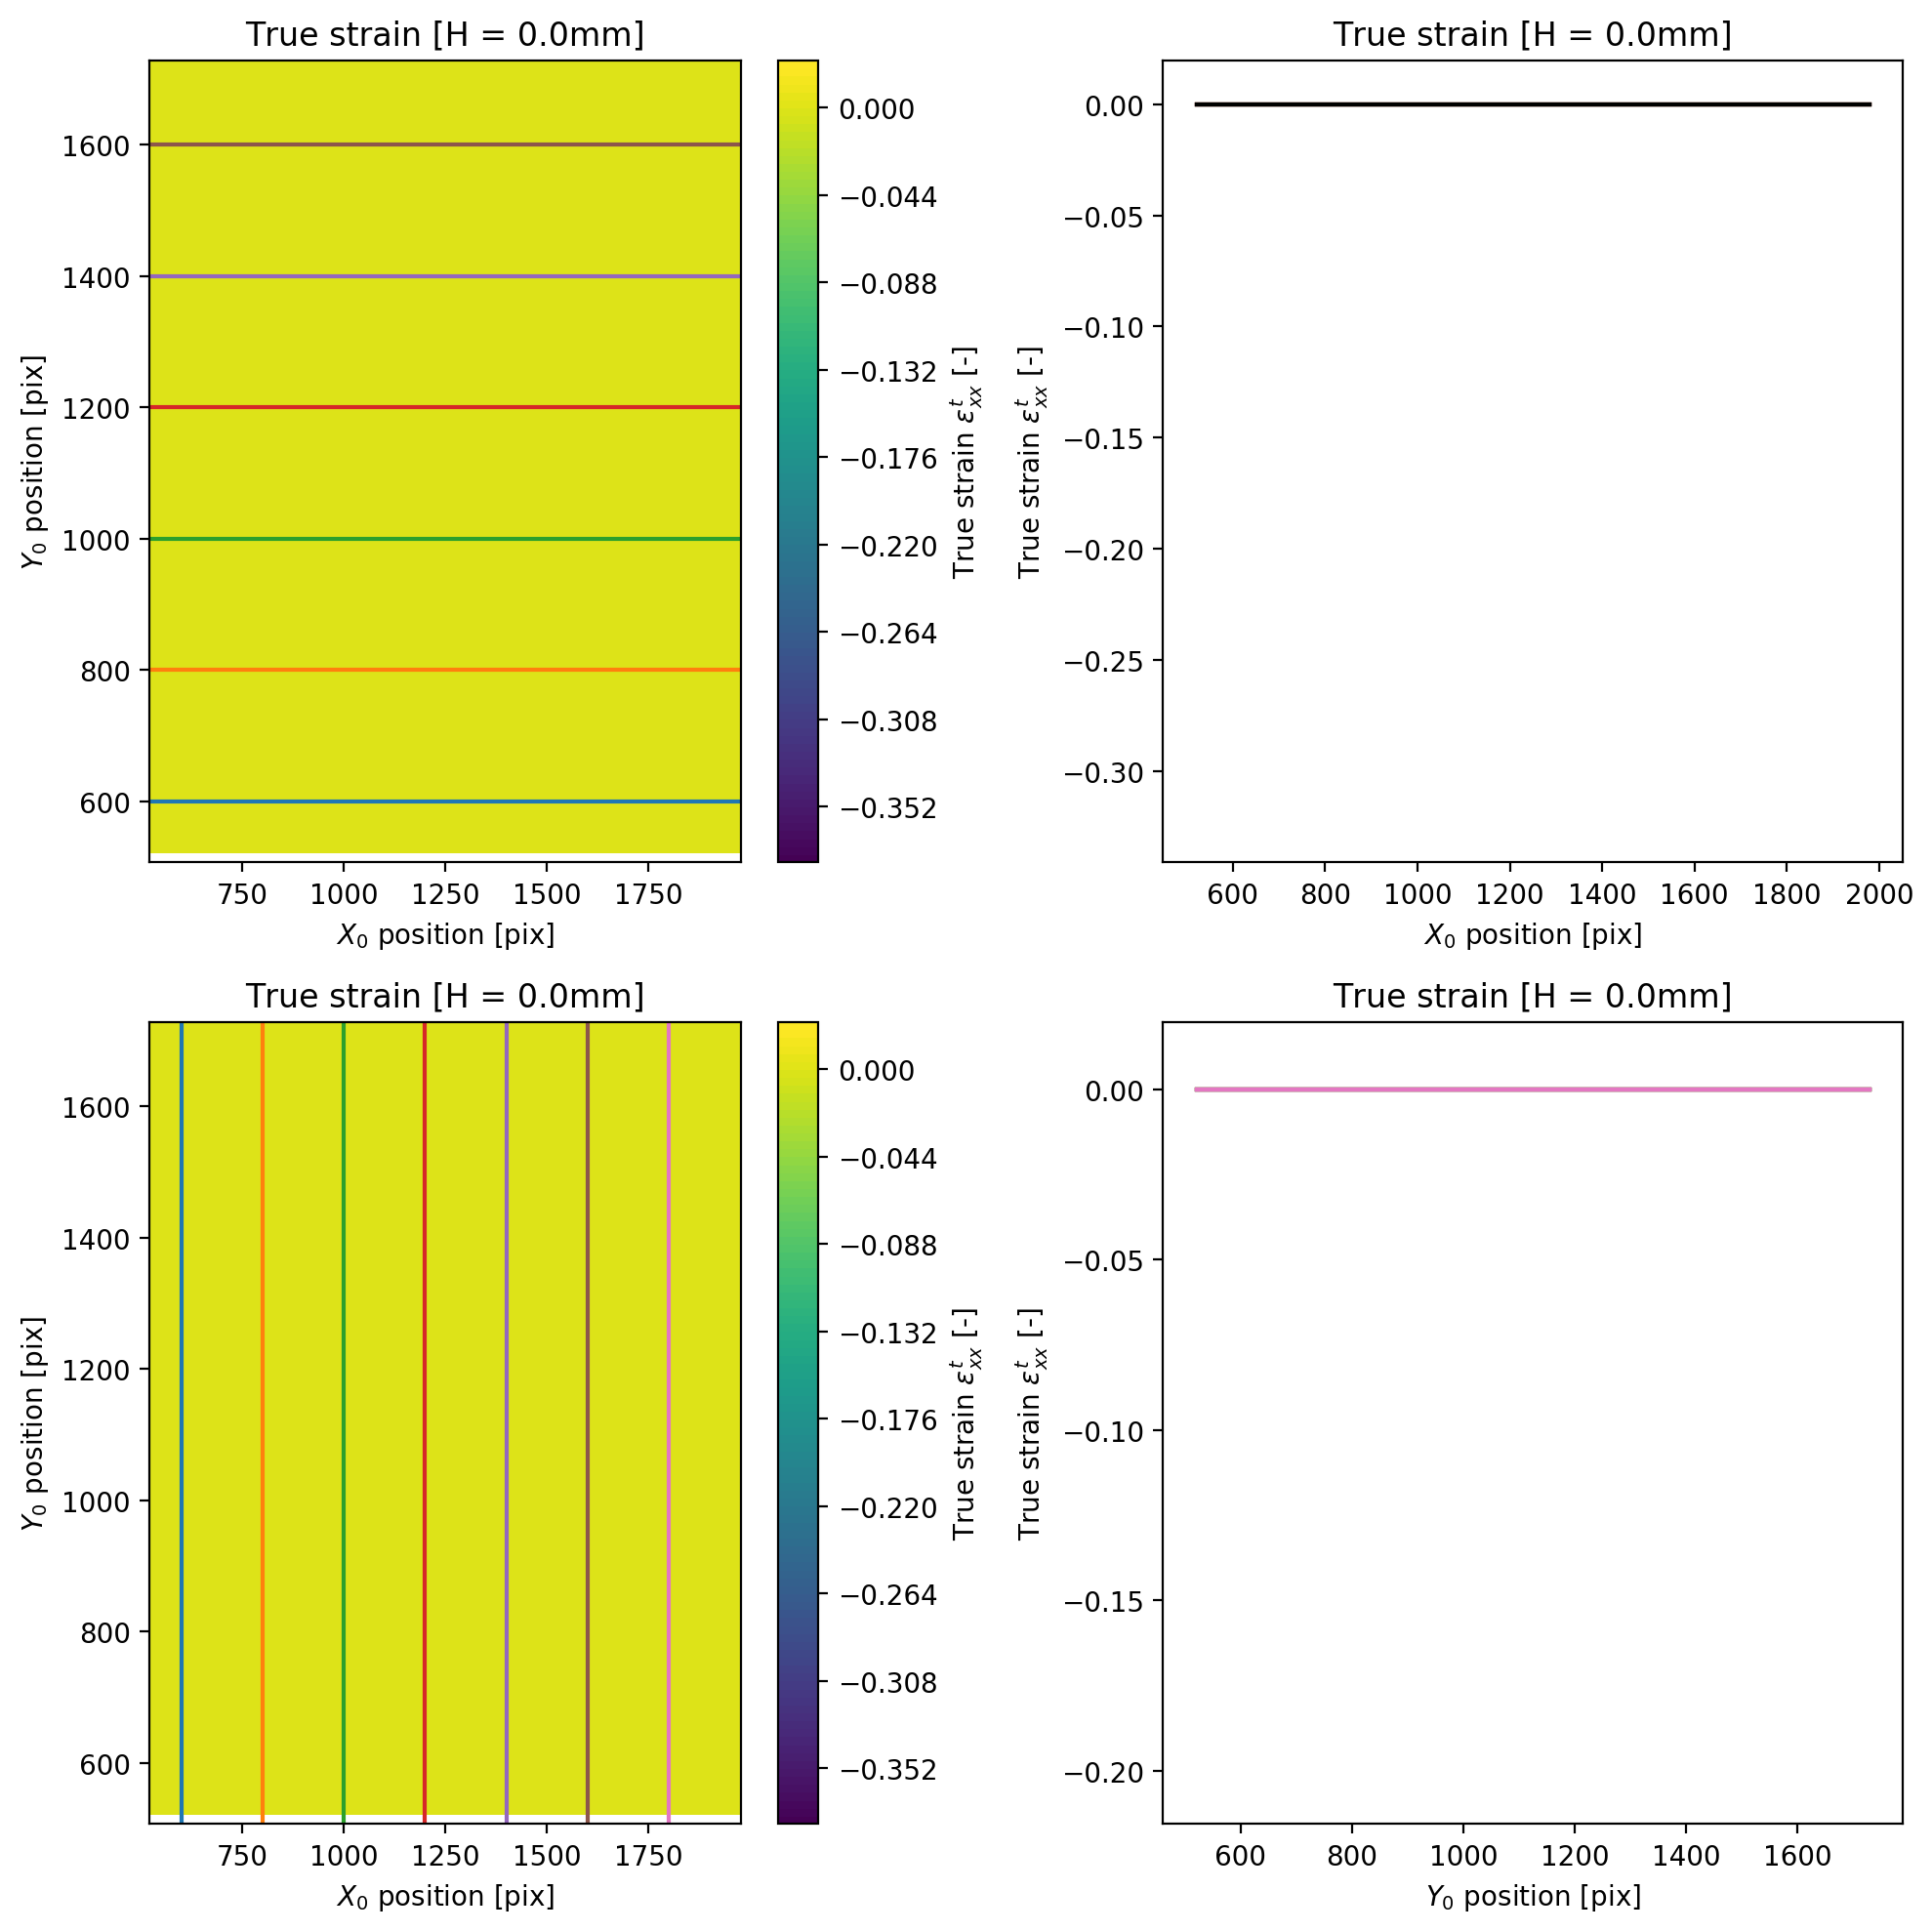

In [36]:
# Animation evolution strain with slices

nbFrames = coords.shape[-1]
frame_index_start = -1

x_pix_list = [600, 800, 1000, 1200, 1400, 1600, 1800]
y_pix_list = [600, 800, 1000, 1200, 1400, 1600]

# Find nearest elements
x_elem_list = []
y_elem_list = []
for y_pix in y_pix_list:
    y_elem = np.argmin(np.abs(y_pix - y0[y0.shape[0]//2,:]))
    y_elem_list.append(y_elem)
for x_pix in x_pix_list:
    x_elem = np.argmin(np.abs(x_pix - x0[:,x0.shape[0]//2]))
    x_elem_list.append(x_elem)


fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=2, tight_layout=True)
fig.set_dpi(200)

# Set labels
for i in range(2):
    ax[i,0].set_title(f"True strain [H = {heights[frame_index_start] * 1e3:.1f}mm]")
    ax[i,0].set_xlabel('$X_0$ position [pix]')
    ax[i,0].set_ylabel('$Y_0$ position [pix]')
ax[0,1].set_xlabel('$X_0$ position [pix]')
ax[1,1].set_xlabel('$Y_0$ position [pix]')
ax[0,1].set_ylabel('True strain $\epsilon^t_{xx}$ [-]')
ax[1,1].set_ylabel('True strain $\epsilon^t_{xx}$ [-]')
ax[0,1].set_title("True strain evolution along $X_0$ position")
ax[1,1].set_title("True strain evolution along $Y_0$ position")

# Set bounds
xbounds_cont = coords[0,0,:,0,:].min(), coords[0,0,:,0,:].max()
ybounds_cont = coords[0,1,:,0,:].min(), coords[0,1,0,:,:].max()
for i in range(2):
    ax[i,0].set_xbound(*xbounds)
    ax[i,0].set_ybound(*ybounds)
ybounds_x = trueStrain[0,0,0,x_elem_list,:,:].min(), trueStrain[0,0,0,x_elem_list,:,:].max()
ybounds_y = trueStrain[0,0,0,:,y_elem_list,:].min(), trueStrain[0,0,0,:,y_elem_list,:].max()
ax[0,1].set_ybound(*ybounds_y)
ax[1,1].set_ybound(*ybounds_x)

# Set static cmap
vmin, vmax = trueStrain[0,0,0,:,:,1:].min(), trueStrain[0,0,0,:,:,1:].max()
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap('viridis')
n_levels = 100

# Plot last frame
x0 = coords[0,0,:,:,0]
y0 = coords[0,1,:,:,0]
trueStrain_frame = trueStrain[0,0,0,:,:,frame_start]

# Contour plots
cont0 = ax[0,0].contourf(x0, y0, trueStrain_frame, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont0, ax=ax[0,0], label="True strain $\epsilon^t_{xx}$ [-]")
cont1 = ax[1,0].contourf(x0, y0, trueStrain_frame, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont1, ax=ax[1,0], label="True strain $\epsilon^t_{xx}$ [-]")

# Line sections
lines_y = [ax[0,1].plot(x0[:,y_elem], trueStrain_frame[:,y_elem], c=color, label=f"Y = {y_pix}pix")
           for y_elem, y_pix, color in zip(y_elem_list, y_pix_list, color_cycle)]
lines_x = [ax[1,1].plot(y0[x_elem,:], trueStrain_frame[x_elem,:], c=color, label=f"X = {x_pix}pix")
           for x_elem, x_pix, color in zip(x_elem_list, x_pix_list, color_cycle)]

# Vert/Horiz lines
lines_horiz_y = [ax[0,0].axhline(y_pix, c=color) for y_pix, color in zip(y_pix_list, color_cycle)]
lines_vert_x = [ax[1,0].axvline(x_pix, c=color) for x_pix, color in zip(x_pix_list, color_cycle)]

line_yAvg = ax[0,1].plot(x0[:,y_elem], trueStrain_frame.mean(axis=1), color='k', label="y-averaged")

def update(frame_index):
    global cont0, cont1, lines_y, lines_x, lines_horiz_y, lines_vert_x, line_yAvg

    trueStrain_frame = trueStrain[0,0,0,:,:,frame_index]
    
    # Remove contours and lines
    for c in cont0.collections + cont1.collections:
        c.remove() 

    # Draw countourf
    cont0 = ax[0,0].contourf(x0, y0, trueStrain_frame, levels=n_levels, cmap=cmap, norm=norm)
    cont1 = ax[1,0].contourf(x0, y0, trueStrain_frame, levels=n_levels, cmap=cmap, norm=norm)
    
    # Plots curves
    for line, line_vert, x_elem in zip(lines_x, lines_vert_x, x_elem_list):
        line[0].set_ydata(trueStrain_frame[x_elem,:])
        #line_vert.set_data([x0[x_elem,0], x0[x_elem,0]], [0,1])
    for line, line_horiz, y_elem in zip(lines_y, lines_horiz_y, y_elem_list):
        line[0].set_ydata(trueStrain_frame[:,y_elem])
        #line_horiz.set_data([0,1], [y0[0,y_elem],y0[0,y_elem]])
    
    line_yAvg[0].set_ydata(trueStrain_frame.mean(axis=1))

    
    # Set limits and title
    for axi in ax.flatten():
        axi.set_title(f"True strain [H = {heights[frame_index] * 1e3:.1f}mm]")
    for axi in ax[:,0]:
        axi.set_xbound(*xbounds)
        axi.set_ybound(*ybounds)
    ax[0,1].set_ybound(*ybounds_y)
    ax[1,1].set_ybound(*ybounds_x)
    
    return cont0, cont1

anim = animation.FuncAnimation(fig, update, frames=nbFrames, repeat=False, interval=100)
print(f"{nbFrames} frames")

anim_html = HTML(anim.to_html5_video())

In [37]:
# Display animation

anim_html

In [38]:
# Save animation

savepath = os.path.join(folder_fields, "animation_trueStrain_slices.html")
with open(savepath, 'w') as f:
    f.write(anim_html.data)

## Study the amout of noise

In [39]:
# Define aliases and compute curvatures

engStrainXX = np.exp(trueStrain[0,0,0]) - 1
engStrainXX_noYavg = engStrainXX - engStrainXX.mean(axis=1)[:,np.newaxis,:]

curvatures = np.empty((engStrainXX.shape[-1], 2))
for i in range(heights.size):
    curvatures[i] = flex.solve_curvature(setup.W, heights[i], setup.a)

x0 = coords[0,0,:,:,0]
y0 = coords[0,1,:,:,0]

[2, 7, 11, 16, 21, 26]


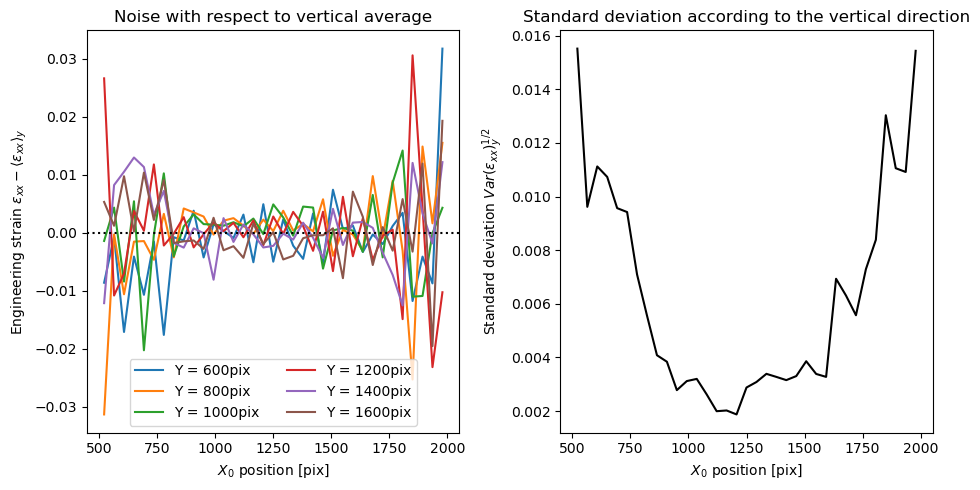

In [40]:
# Plot the engineering strain without y-average

frame_index = -1
y_pix_list = [600, 800, 1000, 1200, 1400, 1600]

# Find nearest elements
y_elem_list = []
for y_pix in y_pix_list:
    y_elem = np.argmin(np.abs(y_pix - y0[y0.shape[0]//2,:]))
    y_elem_list.append(y_elem)
print(y_elem_list)

fig, ax = plt.subplots(figsize=(10,5), ncols=2, tight_layout=True)

# Plot the deviation to y-avg
for y_elem, y_pix in zip(y_elem_list, y_pix_list):
    ax[0].plot(x0[:,y_elem], engStrainXX_noYavg[:,y_elem, frame_index], label=f"Y = {y_pix}pix")
ax[0].axhline(0, c='k', ls=':')

# Plot the evolution of std-deviation
ax[1].plot(x0[:,0], engStrainXX[:,:,frame_index].std(axis=1), 'k')

# Legend and titles
ax[0].legend(loc='lower center', ncol=2)
ax[0].set_xlabel('$X_0$ position [pix]'); ax[1].set_xlabel('$X_0$ position [pix]'); 
ax[0].set_ylabel('Engineering strain $\epsilon_{xx} - \langle \epsilon_{xx} \\rangle_y$')
ax[1].set_ylabel('Standard deviation $Var\\left( \epsilon_{xx} \\right)_y^{1/2}$')
ax[0].set_title("Noise with respect to vertical average")
ax[1].set_title("Standard deviation according to the vertical direction")

plt.show()


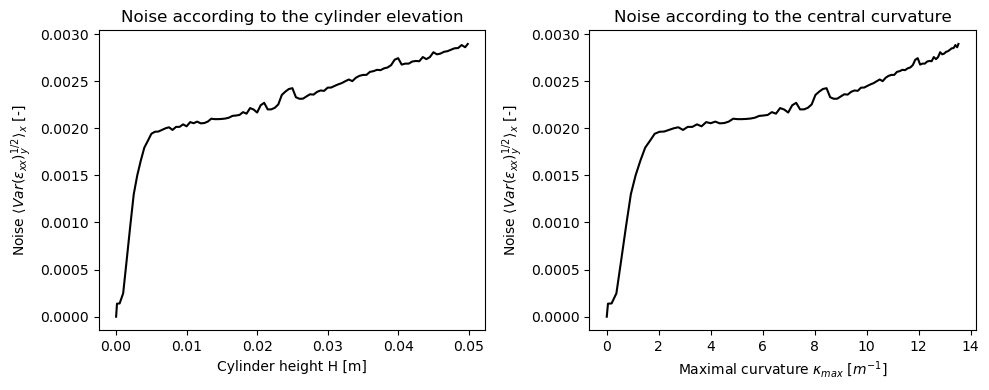

In [41]:
# Plot the evolution of the noise over height and curvature

xBounds_for_noise = [900, 1500]
mask_noise = (xBounds_for_noise[0] < x0[:,0]) & (x0[:,0] < xBounds_for_noise[1])

noise_engStrainXX = engStrainXX[mask_noise,:,:].std(axis=1).mean(axis=0)

fig, ax = plt.subplots(figsize=(10,4), ncols=2, tight_layout=True)
ax[0].set_title("Noise according to the cylinder elevation")
ax[1].set_title("Noise according to the central curvature")

# Plots
ax[0].plot(heights, noise_engStrainXX, 'k', label="$\\langle Var\\left( \epsilon_{xx} \\right)_y^{1/2} \\rangle_x$")
ax[1].plot(curvatures[:,1], noise_engStrainXX, 'k', label="$\\langle Var\\left( \epsilon_{xx} \\right)_y^{1/2} \\rangle_x$")

ax[0].set_xlabel("Cylinder height H [m]")
ax[1].set_xlabel("Maximal curvature $\\kappa_{max}$ [$m^{-1}$]")
for axi in ax:
    axi.set_ylabel("Noise $\\langle Var\\left( \epsilon_{xx} \\right)_y^{1/2} \\rangle_x$ [-]")

plt.show()